# Importing Libraries

In [ ]:
import csv
import os
import re
import nltk as nl
from nltk import PorterStemmer
import string
from sklearn.preprocessing import OneHotEncoder
import itertools
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt

# Extracting data

In [ ]:
train_path = 'airline-tweets-data/airline-train.csv'
dev_path = 'airline-tweets-data/airline-dev.csv'
test_path = 'airline-tweets-data/airline-test.csv'

def extract_data(path):
    texts = []
    Y = []
    with open(path,'r',encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file)
        for line in csv_reader:
            texts.append(line[15])
            y = line[6]
            if y == 'positive':
                Y.append(1)
            elif y == 'neutral':
                Y.append(0)
            elif y == 'negative':
                Y.append(-1)
        Y = np.array(Y)
    return Y, texts

Y_train, texts_train = extract_data(train_path)
Y_dev, texts_dev = extract_data(dev_path)
Y_test, texts_test = extract_data(test_path)



# Preprocessing

In [ ]:
def preprocess(txt_list):

    punctuations = string.punctuation
    ps = PorterStemmer()
    #nl.download('stopwords')
    stopwords = nl.corpus.stopwords.words('english')
    for j in range(len(txt_list)):
        # removing user names
        txt_list[j] = " ".join(filter(lambda x:x[0]!='@', txt_list[j].split()))
        # removing numbers
        txt_list[j] = "".join([c for c in txt_list[j] if not c.isdigit()])
        # removing URLs
        txt_list[j] = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', txt_list[j])
        # removing punctuations
        txt_list[j] = "".join([c for c in txt_list[j] if c not in punctuations])
        # removing stopwords
        tokens = txt_list[j].split(" ")
        clear = ""
        for token in tokens:
            if token not in stopwords:
                clear += (token + " ")
        txt_list[j] = clear
        # length less than 3
        tokens = txt_list[j].split(" ")
        clear = ""
        for token in tokens:
            if len(token) > 2:
                clear += (token + " ")
        txt_list[j] = clear

        # transform to the lower case
        txt_list[j] = txt_list[j].lower()

        # stemming
        tokens = txt_list[j].split(" ")
        tokens = [ tok for tok in tokens if not(tok=='')]
        clear = ''
        for tok in tokens:
            clear += (ps.stem(tok) + " ")
        txt_list[j] = clear[:-1]

    return txt_list

In [ ]:
processed_txt_train = preprocess(texts_train)
processed_txt_train = processed_txt_train[1:]
print(len(processed_txt_train), len(Y_train))

# processed_txt_dev = preprocess(texts_dev)
# processed_txt_dev = processed_txt_dev[1:]
# print(len(processed_txt_dev), len(Y_dev))

# processed_txt_test = preprocess(texts_test)
# processed_txt_test = processed_txt_test[1:]
# print(len(processed_txt_test), len(Y_test))

8784 8784


# Chi square

In [ ]:
def word_counter(dic_freq, s):
    words = s.split(" ")
    for word in words:
        if not word == '':
            if word in dic_freq:
                dic_freq[word] += 1
            else:
                dic_freq[word] = 1

def words_frequency(Y, texts , positive_dic , negative_dic , neutral_dic):
    freq_pos = 0
    freq_neg = 0
    freq_neutral = 0
    for i in range(len(Y)):
        y = Y[i]
        if y == 1:
            word_counter(positive_dic, texts[i])
            freq_pos += 1
        elif y == -1:
            word_counter(negative_dic, texts[i])
            freq_neg += 1
        else:
            word_counter(neutral_dic, texts[i])
            freq_neutral += 1
    return freq_pos, freq_neg, freq_neutral

def ChiSquare(dic_pos, dic_neg, dic_neutral, freq_pos, freq_neg, freq_neutral, N):

    chi_pos = {}
    chi_neg = {}
    chi_neutral = {}

    # Possitive
    for word,value in dic_pos.items():
        A = value
        C = freq_pos - A
        if word in dic_neg:
            N1= dic_neg[word]
        else:
            N1=0
        if word in dic_neutral:
            N2= dic_neutral[word]
        else:
            N2=0
        B = N1 + N2
        D = freq_neutral + freq_neg - B
        X = N*(A*D - C*B)/((A+C)*(B+D)*(A+B)*(C+D))
        chi_pos[word]=round(X*1000,3)

    # Negative
    for word,value in dic_neg.items():
        A = value
        C = freq_neg - A
        if word in dic_pos:
            N1= dic_pos[word]
        else:
            N1=0
        if word in dic_neutral:
            N2= dic_neutral[word]
        else:
            N2=0
        B = N1 + N2
        D = freq_neutral + freq_pos - B
        X = N*(A*D - C*B)/((A+C)*(B+D)*(A+B)*(C+D))
        chi_neg[word]=round(X*10000,3)

    # Neutral
    for word,value in dic_neutral.items():
        A = value
        C = freq_neutral - A
        if word in dic_pos:
            N1= dic_pos[word]
        else:
            N1=0
        if word in dic_neg:
            N2= dic_neg[word]
        else:
            N2=0
        B = N1 + N2
        D = freq_pos + freq_neg - B
        X = N*(A*D - C*B)/((A+C)*(B+D)*(A+B)*(C+D))
        chi_neutral[word]= round(X*10000,3)

    return chi_pos, chi_neg, chi_neutral

def keep_influencial_words(chi):
    temp = {}
    for word,value in chi.items():
        if value > 0.1:
            temp[word] = value
    return temp


In [ ]:
dic_freq_pos = {}
dic_freq_neg = {}
dic_freq_neutral = {}

freq_pos, freq_neg, freq_neutral = words_frequency(Y_train, processed_txt_train , dic_freq_pos , dic_freq_neg , dic_freq_neutral)
N = len(Y_train)
print(N, freq_pos, freq_neg, freq_neutral)

chi_pos, chi_neg, chi_neutral = ChiSquare(dic_freq_pos, dic_freq_neg, dic_freq_neutral, freq_pos, freq_neg, freq_neutral, N)

chi_pos = keep_influencial_words(chi_pos)
chi_neg = keep_influencial_words(chi_neg)
chi_neutral = keep_influencial_words(chi_neutral)

8784 1447 5547 1790


# Naive Bayes classifier

In [ ]:
def frequency_words(dic):
    freq = 0
    for word,frequency in dic.items():
        freq += frequency
    return freq


def prob_words(dic, freq):
    temp_dic = {}
    for word,frequency in dic.items():
        temp_dic[word]= (frequency + 1) / (freq + len(dic))
    return temp_dic

def Probability(words,y, prob_pos, prob_neg, prob_neutral, N_words_pos, N_words_neg, N_words_neutral):
    result = 1
    if y == "positive":
        for word in words:
            if word in prob_pos:
                result *= prob_pos[word]
            else:
                result *= 1 / (N_words_pos + len(prob_pos))
    if y == "negative":
        for word in words:
            if word in prob_neg:
                result *= prob_neg[word]
            else:
                result *= 1 / (N_words_neg + len(prob_neg))
    if y == "neutral":
        for word in words:
            if word in prob_neutral:
                result *= prob_neutral[word]
            else:
                result *= 1 / (N_words_neutral + len(prob_neutral))
    return result

N_words_pos = frequency_words(dic_freq_pos)
N_words_neg = frequency_words(dic_freq_neg)
N_words_neutral = frequency_words(dic_freq_neutral)
prob_pos = prob_words(dic_freq_pos, N_words_pos)
prob_neg = prob_words(dic_freq_neg, N_words_neg)
prob_neutral = prob_words(dic_freq_neutral, N_words_neutral)


def Naive_Bayes(txt_input):
    processed_txt = preprocess(txt_input)
    output = []
    for txt in processed_txt:
        words = txt.split(" ")
        result = {}
        result[1] = Probability(words, "positive", prob_pos, prob_neg, prob_neutral,
                                   N_words_pos, N_words_neg, N_words_neutral)
        result[-1] = Probability(words, "negative", prob_pos, prob_neg, prob_neutral,
                                    N_words_pos, N_words_neg, N_words_neutral)
        result[0] = Probability(words, "neutral", prob_pos, prob_neg, prob_neutral,
                                   N_words_pos, N_words_neg, N_words_neutral)
        result = sorted(result.items(), key=lambda x: x[1], reverse=True)
        output.append(result[0][0])
    np.array(output)
    return output


# Online data processing
Just Enter the sentences you want in an array. The rest will be taken care of :)
positive -> 1,       neutral -> 0,      negative -> -1

In [ ]:
print(Naive_Bayes(["@united no, didn't notice I was 38A until start of boarding. Assumed I was 8E.",
                  '@JetBlue thanks for your reply. It was flight 1572.',
                 '@SouthwestAir is really gonna hear my mouth about this bag situation.',
                 '@AmericanAir they did tell that our luggage stayed inside the plane ! Look this video http://t.co/YokkHHQcMP']))

[0, 1, 1, -1]


# Accuracy and Confusion matrix

In [ ]:
def param_calculator(tp, fp, fn, tn, m):
    acc = (tp + tn) / m
    pre = tp / (tp + fp)
    recall = tp / (tp + fn)
    f = 2*pre*recall / (pre + recall)
    return acc, pre, recall, f

def accuracy_confusion_mat(Y, predict):
    pos_pos = 0
    pos_net = 0
    pos_neg = 0
    net_pos = 0
    net_net = 0
    net_neg = 0
    neg_pos = 0
    neg_net = 0
    neg_neg = 0
    m = len(Y)
    for i in range(m):
        if Y[i] == 1:
            if predict[i] == 1:
                pos_pos += 1
            elif predict[i] == 0:
                pos_net += 1
            else:
                pos_neg += 1
        elif Y[i] == 0:
            if predict[i] == 1:
                net_pos += 1
            elif predict[i] == 0:
                net_net += 1
            else:
                net_neg += 1
        else:
            if predict[i] == 1:
                neg_pos += 1
            elif predict[i] == 0:
                neg_net += 1
            else:
                neg_neg += 1
    # positive
    tp_pos = pos_pos
    fn_pos = pos_neg + pos_net
    fp_pos = neg_pos + net_pos
    tn_pos = m - tp_pos - fn_pos - fp_pos
    acc_pos, pre_pos, recall_pos, f_pos = param_calculator(tp_pos, fp_pos, fn_pos, tn_pos, m)


    # negative
    tp_neg = neg_neg
    fn_neg = neg_pos + neg_net
    fp_neg = pos_neg + net_neg
    tn_neg = m - tp_neg - fn_neg - fp_neg
    acc_neg, pre_neg, recall_neg, f_neg = param_calculator(tp_neg, fp_neg, fn_neg, tn_neg, m)

    # neutral
    tp_net = net_net
    fn_net = net_pos + net_neg
    fp_net = pos_net + neg_net
    tn_net = m - tp_net - fn_net - fp_net
    acc_net, pre_net, recall_net, f_net = param_calculator(tp_net, fp_net, fn_net, tn_net, m)

    # plot confusion matrix
    data_pos = np.array([['Confusion Matrix (positive)', 'correct', 'not-correct'], ['selected', tp_pos, fp_pos]
                     ,['not-selected' , fn_pos, tn_pos]])
    data_neg = np.array([['Confusion Matrix (negative)', 'correct', 'not-correct'], ['selected', tp_neg, fp_neg]
                     ,['not-selected' , fn_neg, tn_neg]])
    data_net = np.array([['Confusion Matrix (neutral)', 'correct', 'not-correct'], ['selected', tp_net, fp_net]
                     ,['not-selected' , fn_net, tn_net]])

    fig, axs = plt.subplots(4)

    The_Table = axs[0].table(cellText=data_pos, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.5, 1.5)
    axs[0].axis('off')
    #axs[0].title('Confusion matrix')

    The_Table = axs[1].table(cellText=data_neg, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.5, 1.5)
    axs[1].axis('off')
    #axs[1].title('Confusion matrix')

    The_Table = axs[2].table(cellText=data_net, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.5, 1.5)
    axs[2].axis('off')
    #axs[2].title('Confusion matrix')

    data = np.array([['', 'accuracy', 'precision', 'recall', 'F_1'],
                    ['positive', round(acc_pos,5), round(pre_pos,5), round(recall_pos,5), round(f_pos,5)],
                    ['negative', round(acc_neg,5), round(pre_neg,5), round(recall_neg,5), round(f_neg,5)],
                   ['neutral', round(acc_net,5), round(pre_net,5), round(recall_net,5), round(f_net,5)]])

    The_Table = axs[3].table(cellText=data, loc='center',cellLoc='center')
    The_Table.set_fontsize(10)
    The_Table.scale(1.2, 1.2)
    axs[3].axis('off')
    #axs[2].title('Confusion matrix')

    #seting every cell settings

    plt.savefig("table.png")

    acc = (pos_pos + neg_neg + net_net) / m * 100

    return round(acc,3)


## Accuracy and confusion matrix of train set

Accuracy of train set =  75.911


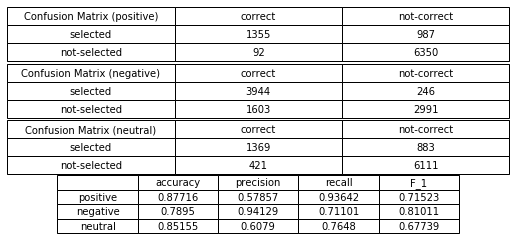

In [ ]:
predict_train = Naive_Bayes(texts_train[1:])
acc = accuracy_confusion_mat(Y_train, predict_train)
print('Accuracy of train set = ', acc)

## Accuracy and confusion matrix of dev set

Accuracy of dev set =  67.964


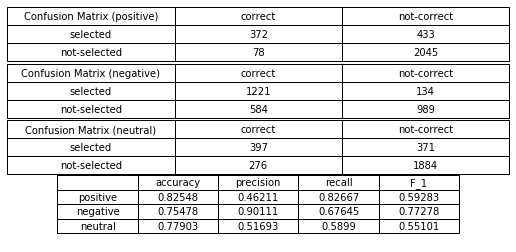

In [ ]:
predict_dev = Naive_Bayes(texts_dev[1:])
acc = accuracy_confusion_mat(Y_dev, predict_dev)
print('Accuracy of dev set = ', acc)

## Accuracy and confusion matrix of test set

Accuracy of test set =  69.501


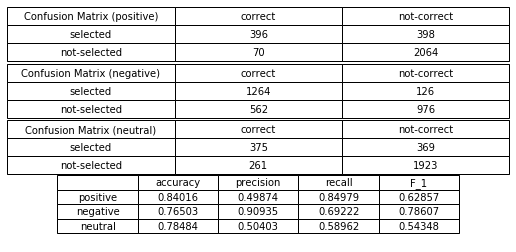

In [ ]:
predict_test = Naive_Bayes(texts_test[1:])
acc = accuracy_confusion_mat(Y_test, predict_test)
print('Accuracy of test set = ', acc)